### Importing

In [1]:
from dataclasses import dataclass
import pandas as pd
from typing import Dict, List
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
from collections import defaultdict

from importlib import reload

import src.processing

reload(src.processing)

from src.processing import Eis_sweep
from src.processing import Ref_impedance
from src.processing import Ac_correction
from src.processing import Type, Name
from src.processing import plot_muliple_nyquist, save_data, plot_muliple_bode, plot_mulitple_bode_comparion, plot_multiple_std_dev


### Defining low frequency correction

In [2]:
# CT600 Zag
gain_factors =  {'CH2': 0.935849404, 'CH3': 0.943915143/1.02136, 'CH4' : 0.974052759/1.027517}

# CT600 JLR
#gain_factors =  {'CH1': 1, 'CH2': 1}

# CT600 PowrCO AMH
#gain_factors =  {'CH1': 1, 'CH2': 1, 'CH3': 0.4502/0.4381, 'CH4': 0.4502/0.4381}

### Importing EIS sweep data

In [3]:
path = 'Data_ref_gen2_powerCo_fixture'
eis_sweeps = []
eis_sweeps_corr = []

folder_path = Path(path)
folders = [f.name for f in folder_path.iterdir() if f.is_dir()]

for folder in folders:
    file_names = [f.name for f in (Path(folder_path) / Path(folder)).iterdir()]
    for file_name in file_names:
        eis_sweep = Eis_sweep(file_path =  Path(folder_path) / Path(folder) / Path(file_name), type = Type.Ref, name = Name.Legacy)
        eis_sweeps.append(eis_sweep)

### Importing ref impedance data

In [4]:
path = 'Data_ref_gen2'
refs = dict()
folder_path = Path(path)
file_names = [f.name for f in folder_path.iterdir()]

for file_name in file_names:
    ref = Ref_impedance(file_path =  Path(path) /  Path(file_name))
    refs[ref.impedance_value] = ref

### Applaying dc correction

In [5]:
for eis_sweep in eis_sweeps:
    eis_sweep.apply_dc_correction(gain_factors[eis_sweep.channel])

KeyError: 'long'

### Calculating AC correction

In [6]:
impedance_value_1 = '2mOhm_gen2'
impedance_value_2 = '250uOhm_gen2'
ac_correct_dict = {}
eis_sweep_ref_1 = {}
eis_sweep_ref_2 = {}

for eis_sweep in eis_sweeps:
    if eis_sweep.impedance_value == impedance_value_1 and eis_sweep.run_number == 1:
        eis_sweep_ref_1[eis_sweep.channel] = eis_sweep
    if eis_sweep.impedance_value == impedance_value_2 and eis_sweep.run_number == 1:
        eis_sweep_ref_2[eis_sweep.channel] = eis_sweep

for channel in eis_sweep_ref_1:
    ac_correct_dict[channel] = Ac_correction(refs[impedance_value_1], refs[impedance_value_2],
                                             eis_sweep_ref_1[channel],     eis_sweep_ref_2[channel], smooth=True)
    


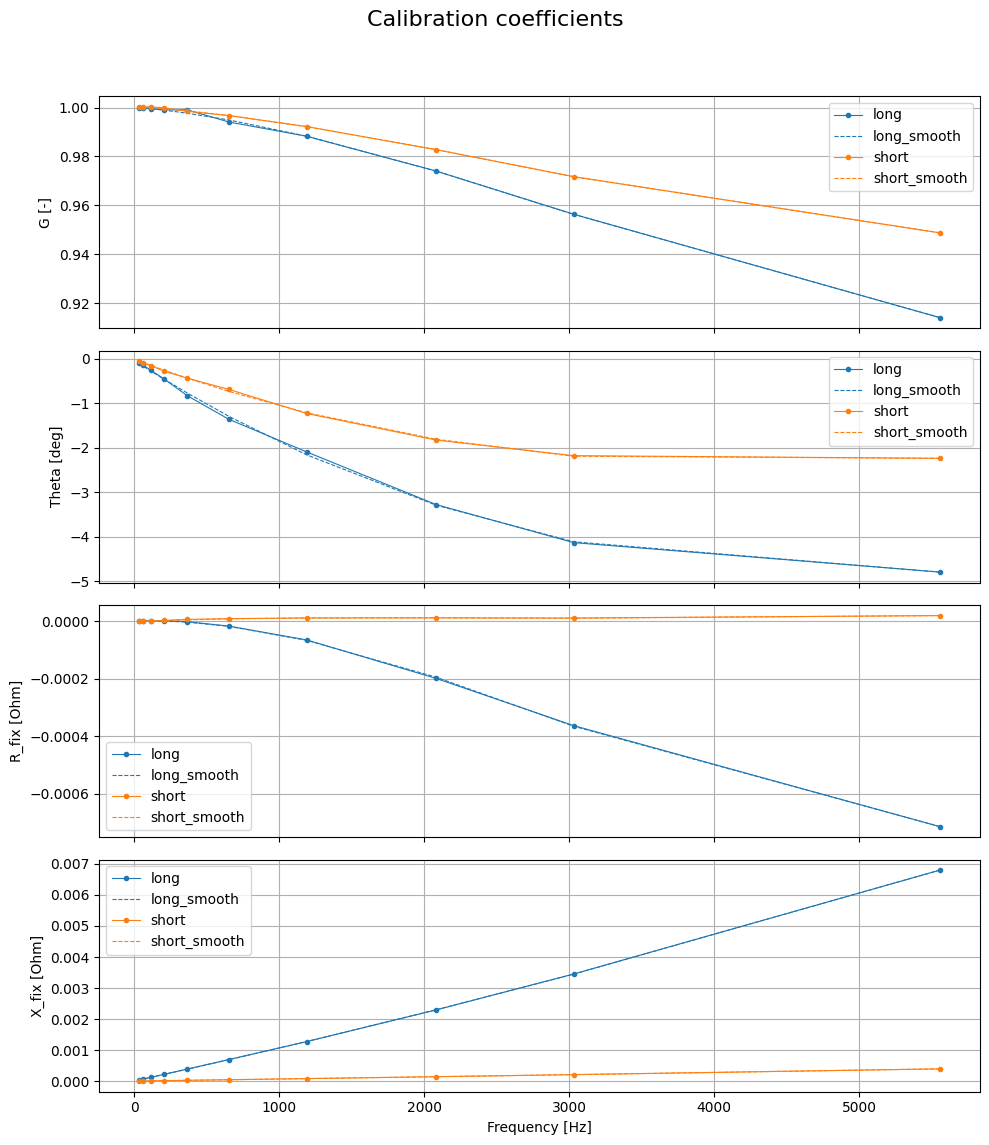

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

columns = ['G', 'theta', 'R_fix', 'X_fix']
axes_names = ['G [-]', 'Theta [deg]', 'R_fix [Ohm]', 'X_fix [Ohm]']

fig, axes = plt.subplots(len(columns), 1, figsize=(10, 12), sharex=True)
fig.suptitle('Calibration coefficients', fontsize=16)

for channel in ac_correct_dict:
    df        = ac_correct_dict[channel].corr_coef_raw_df
    df_smooth = ac_correct_dict[channel].corr_coef_df
    # Save to CSV with channel prefix
    df.to_csv(f'{channel}_corr_coef_raw.csv', index=False)
    df_smooth.to_csv(f'{channel}_corr_coef_smooth.csv', index=False)

for channel in ac_correct_dict:
    df        = ac_correct_dict[channel].corr_coef_raw_df
    df_smooth = ac_correct_dict[channel].corr_coef_df

    for i, col in enumerate(columns):
        line, = axes[i].plot(df['Frequency'], df[col], '.', label=channel)
        axes[i].plot(df_smooth['Frequency'], df_smooth[col], '--', label=channel + '_smooth', color = line.get_color())
        axes[i].set_ylabel(axes_names[i])
        axes[i].legend()
        axes[i].grid(True)

    axes[-1].set_xlabel('Frequency [Hz]')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Applaying AC correction

In [41]:
from copy import deepcopy
eis_sweeps_ac_corr = deepcopy(eis_sweeps)
for eis_sweep in eis_sweeps_ac_corr:
    eis_sweep.apply_ac_correction(ac_correct_dict[eis_sweep.channel])  

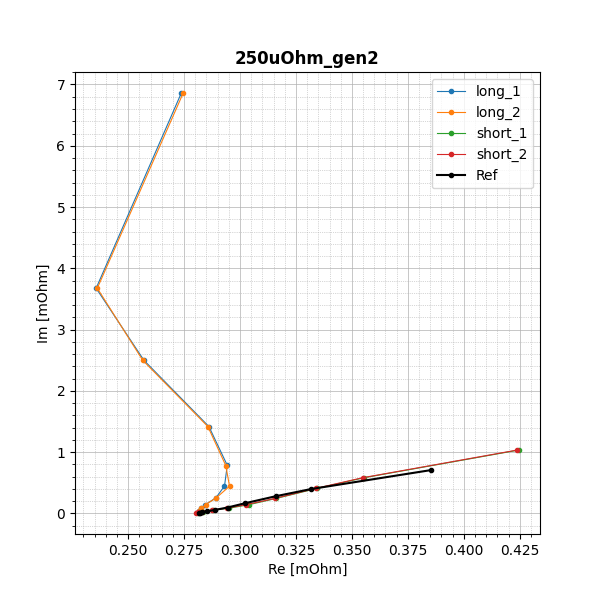

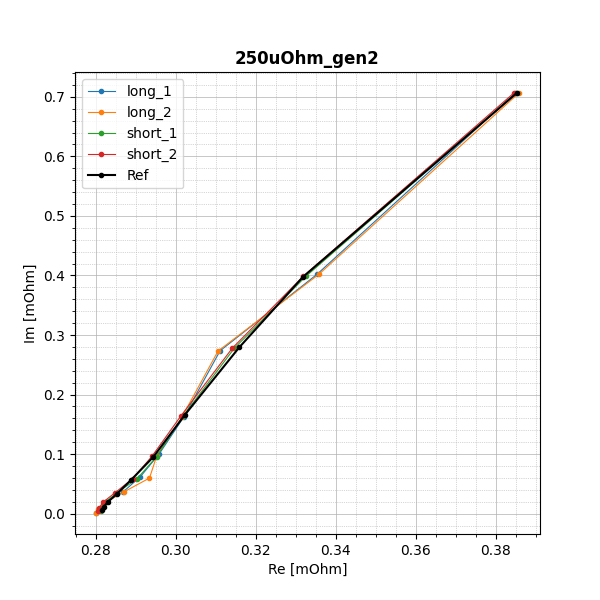

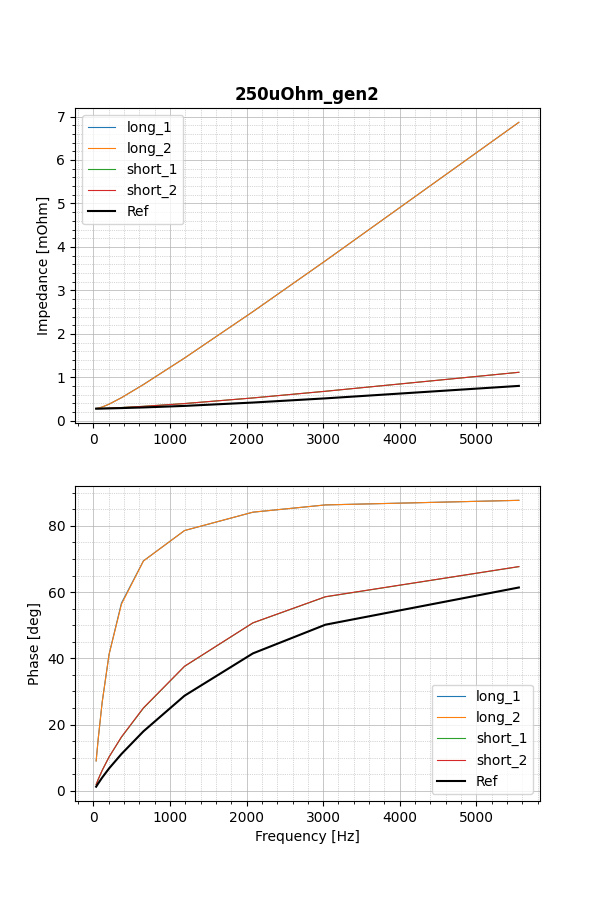

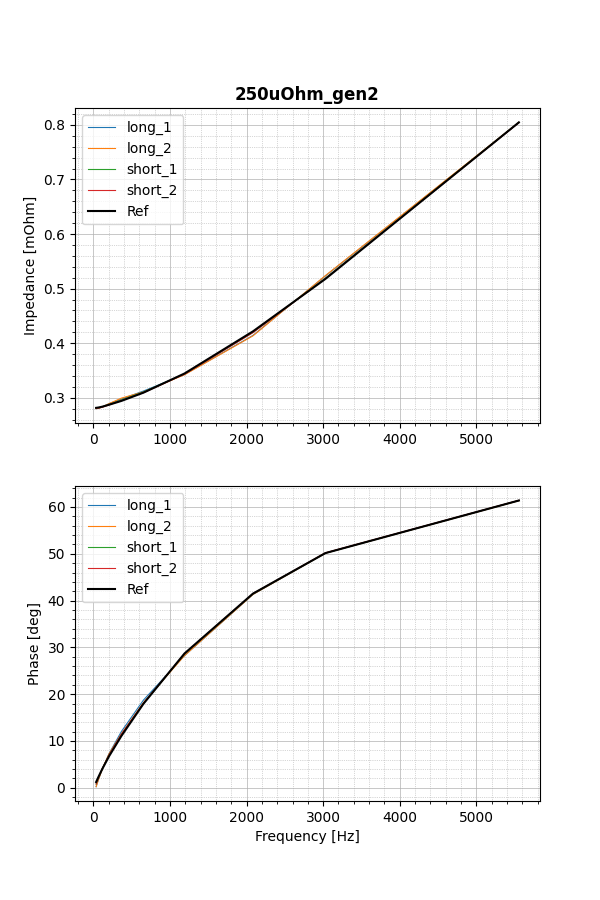

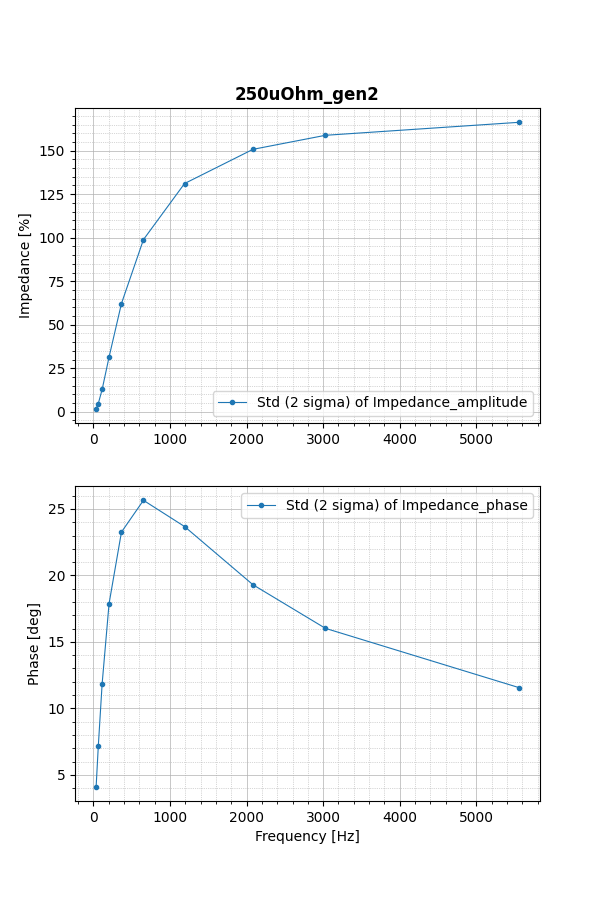

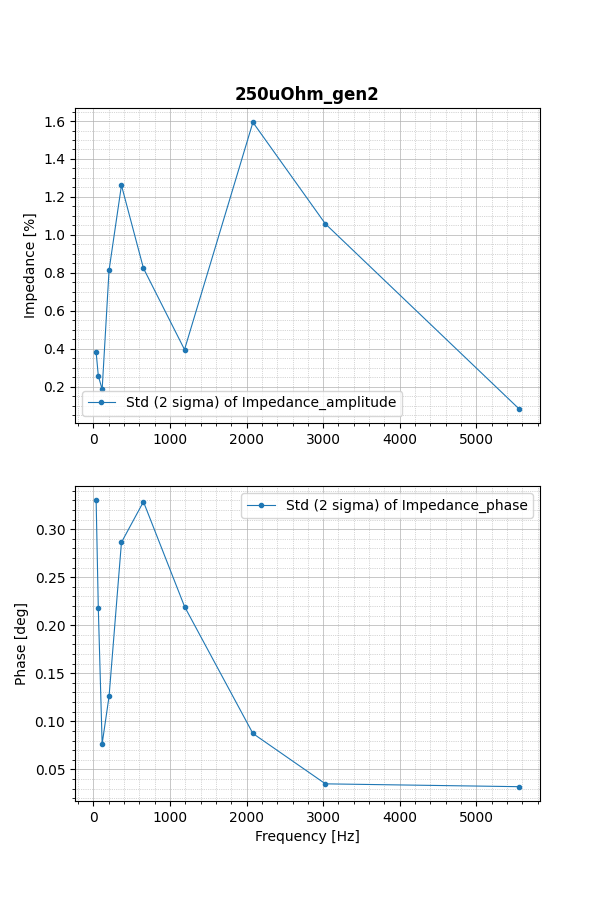

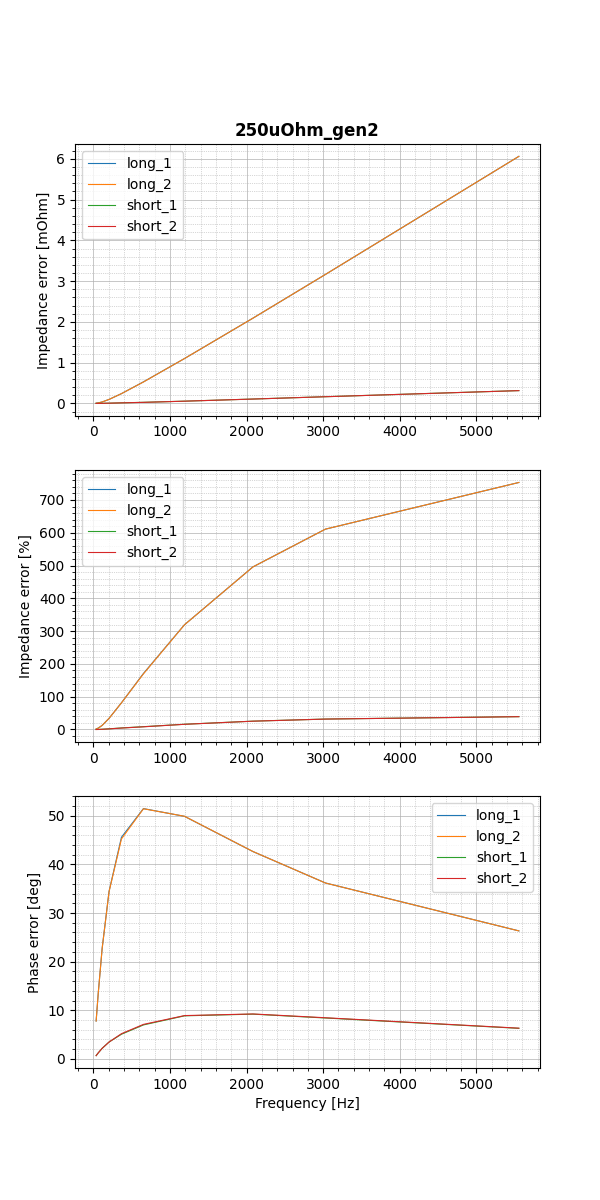

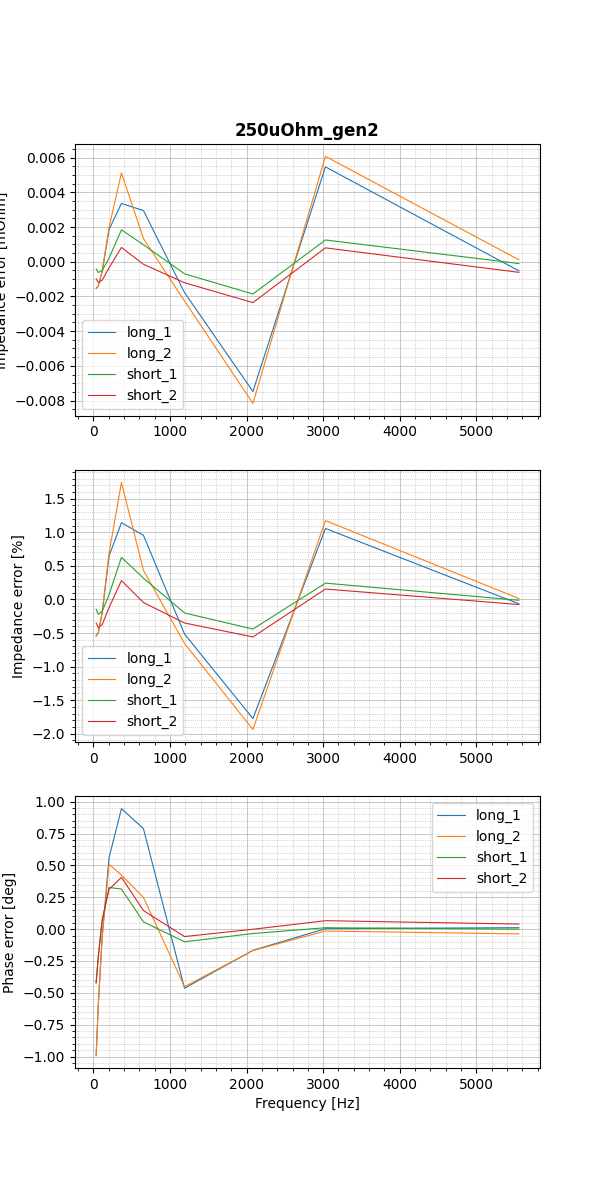

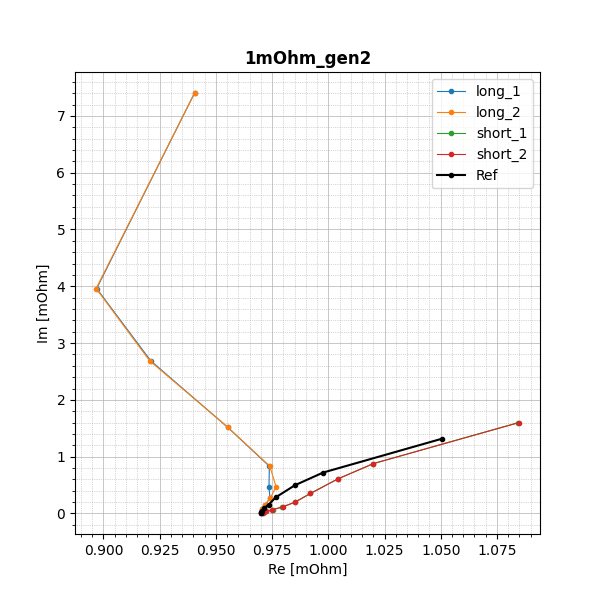

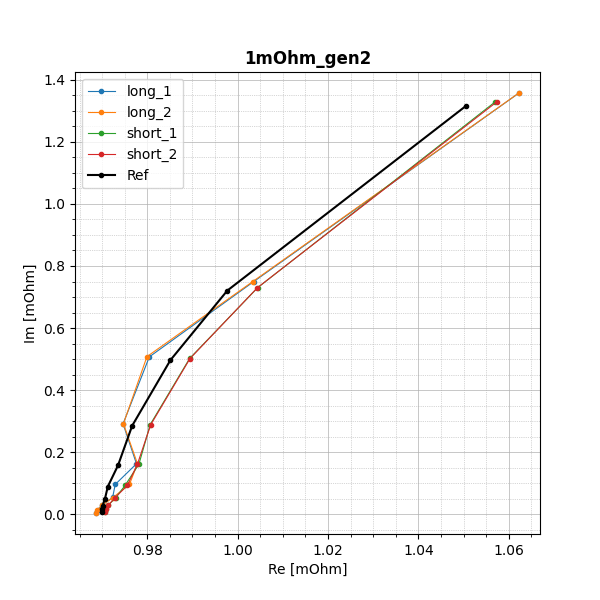

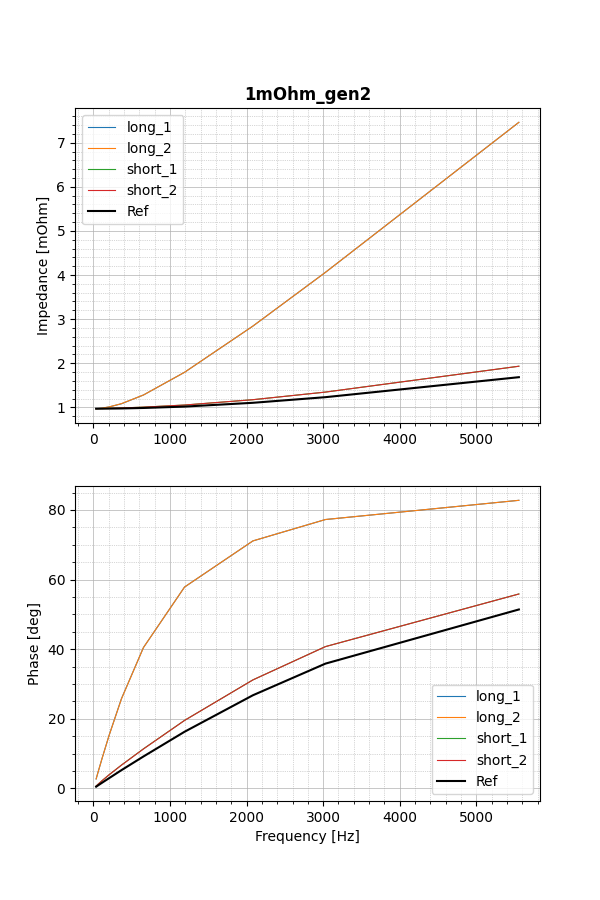

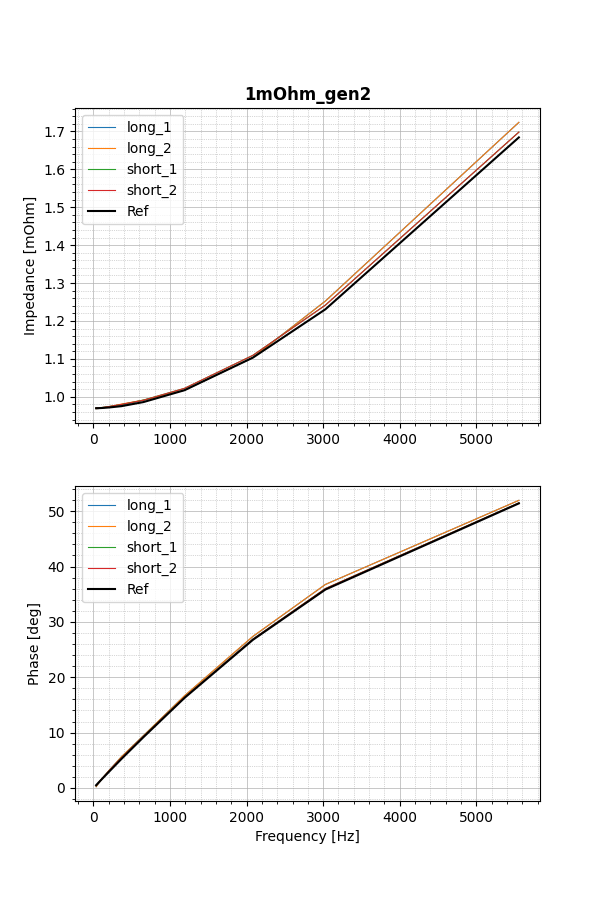

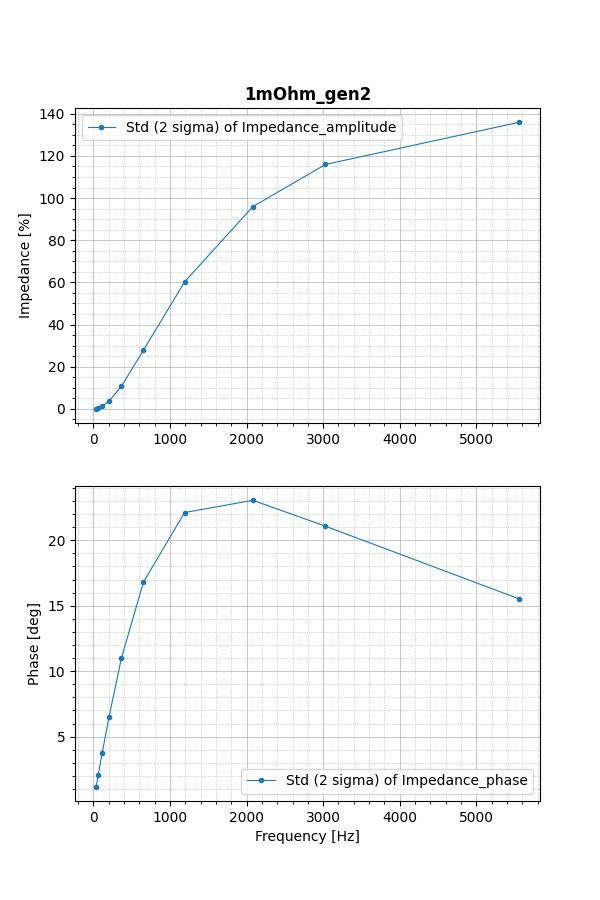

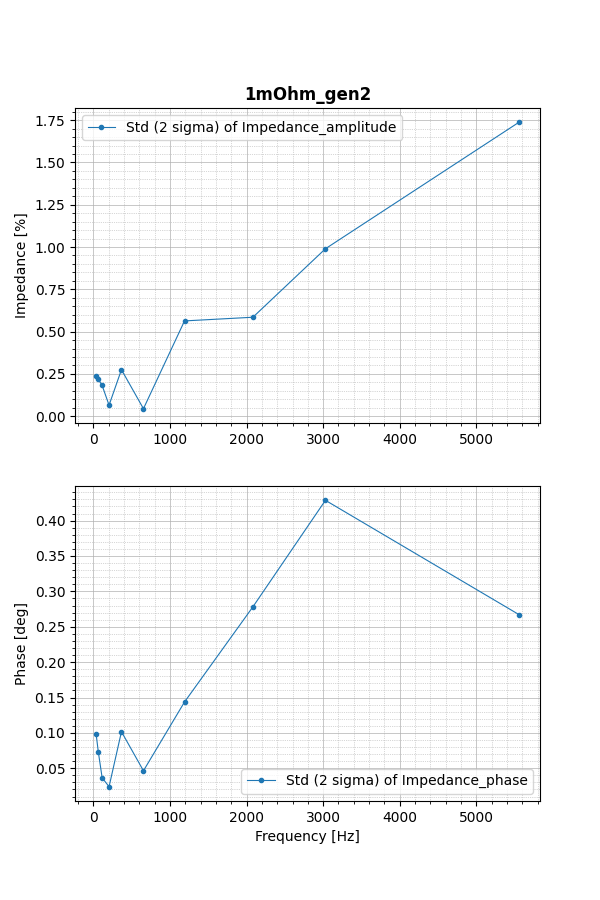

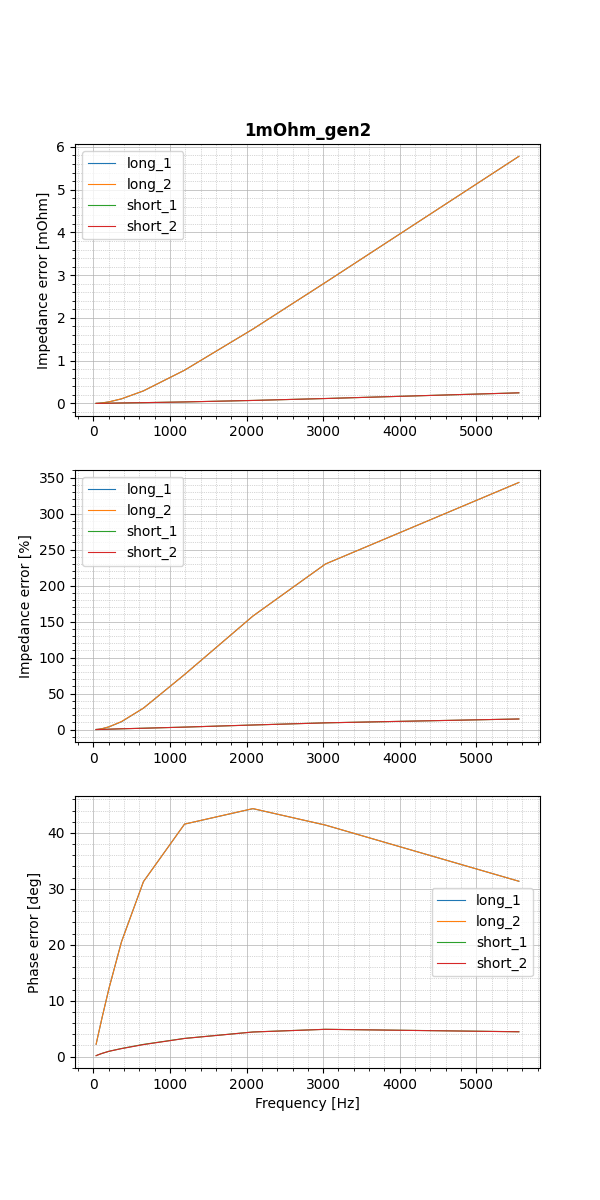

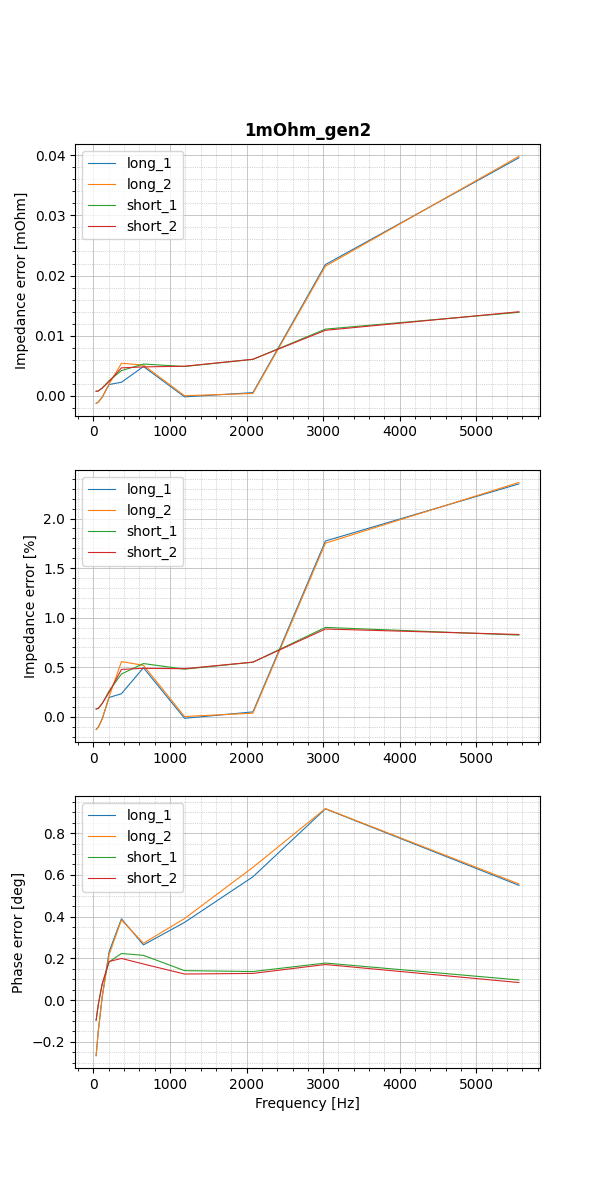

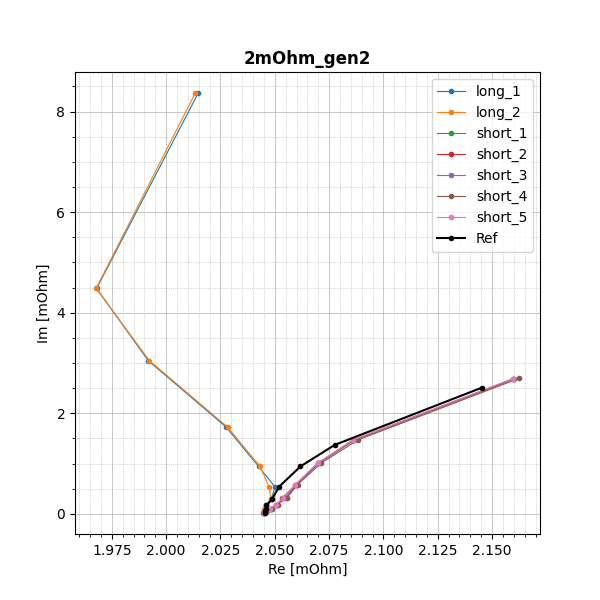

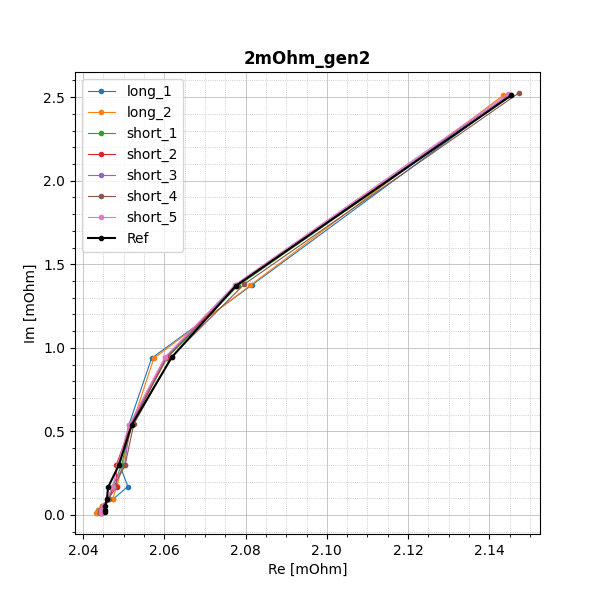

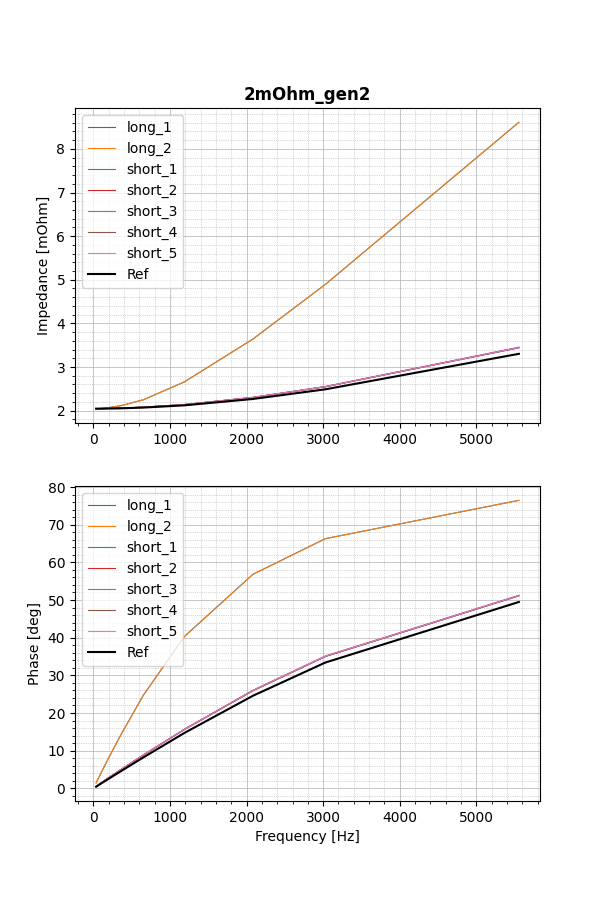

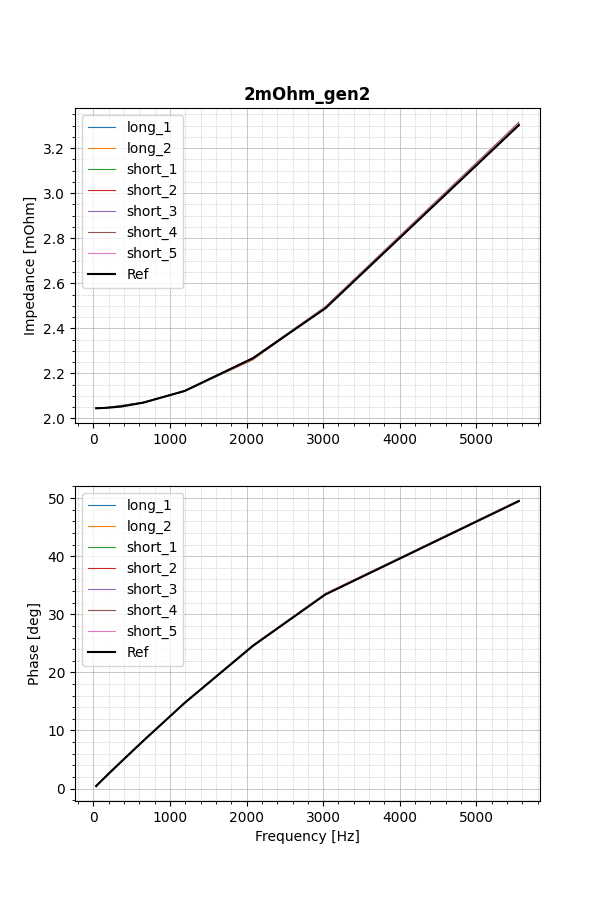

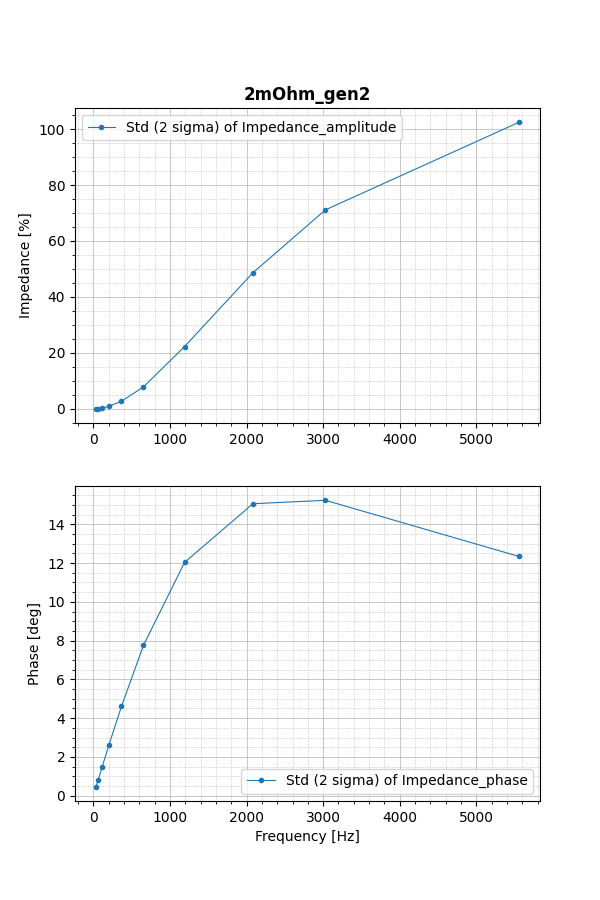

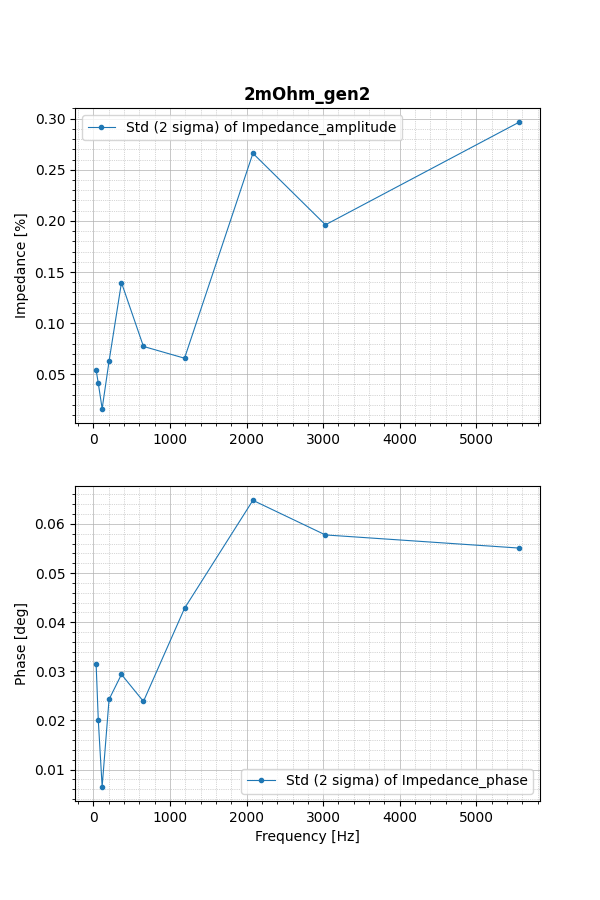

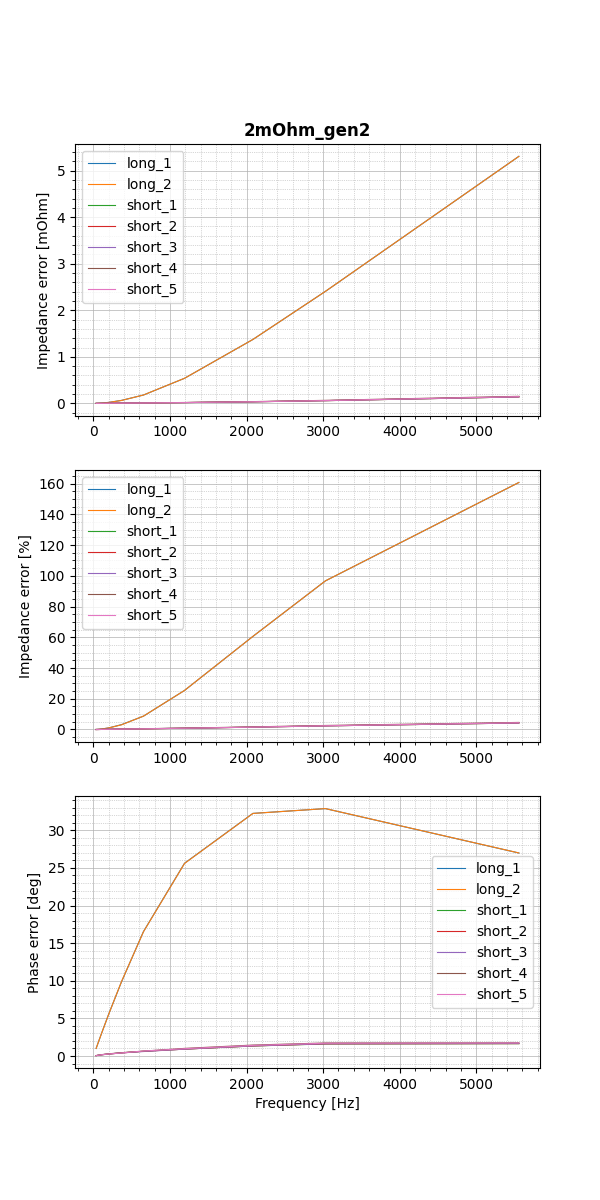

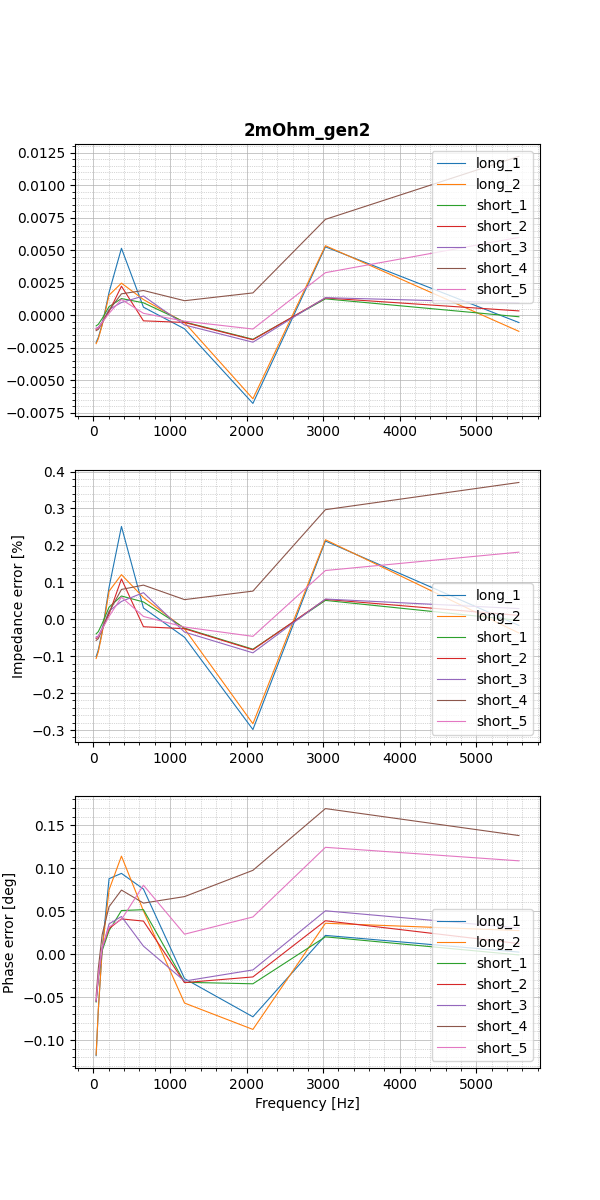

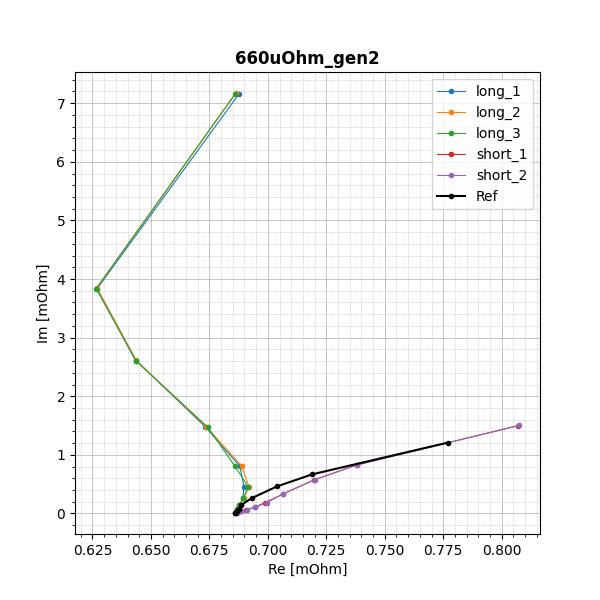

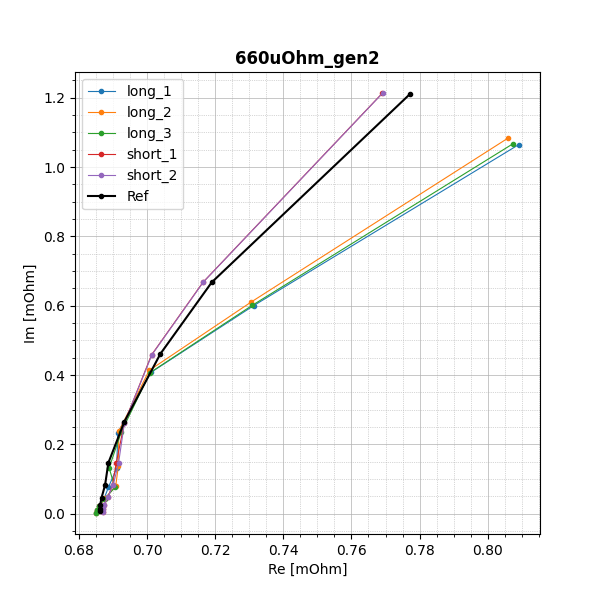

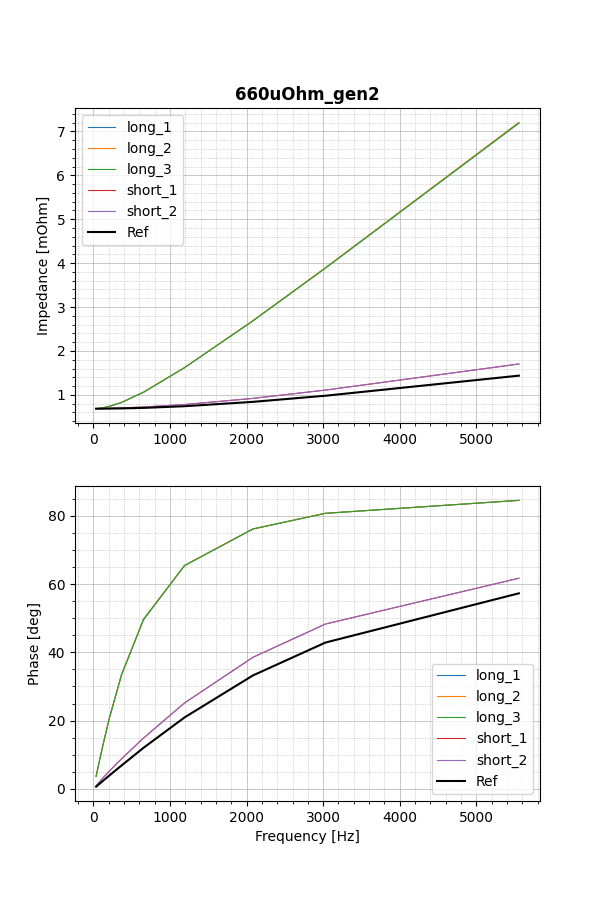

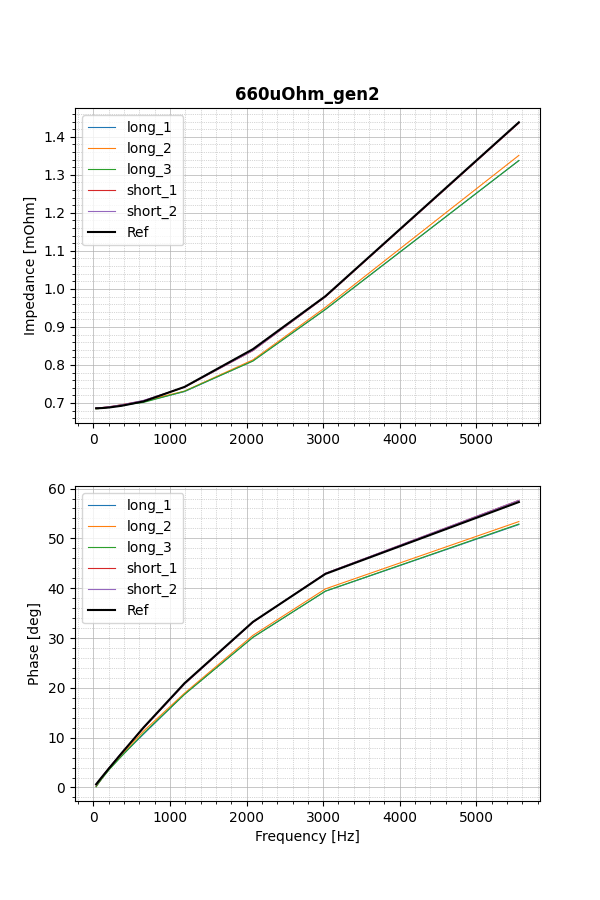

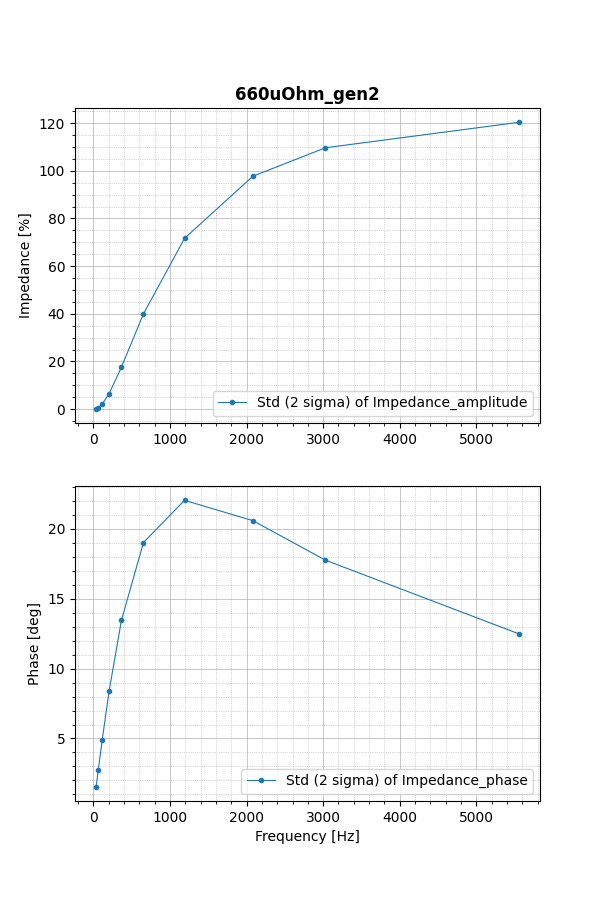

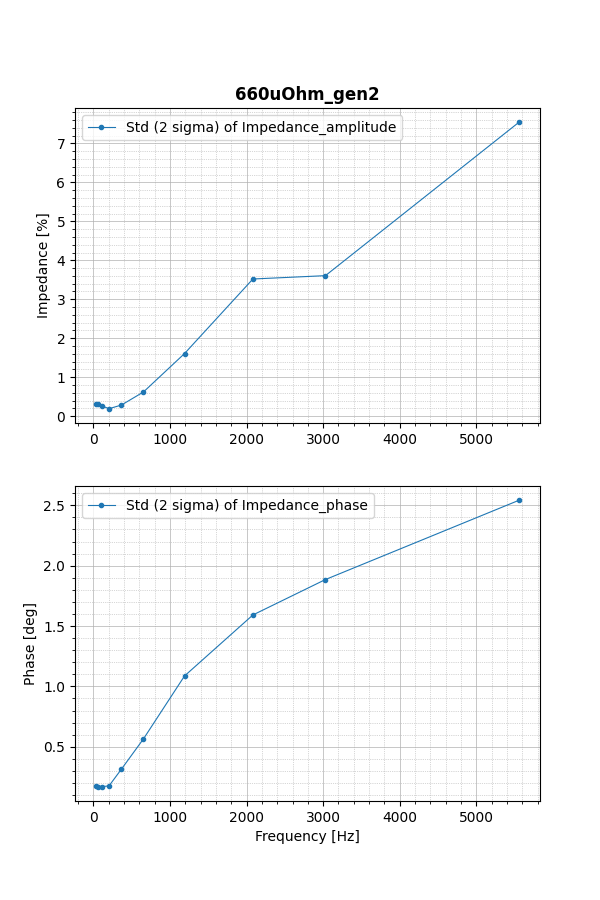

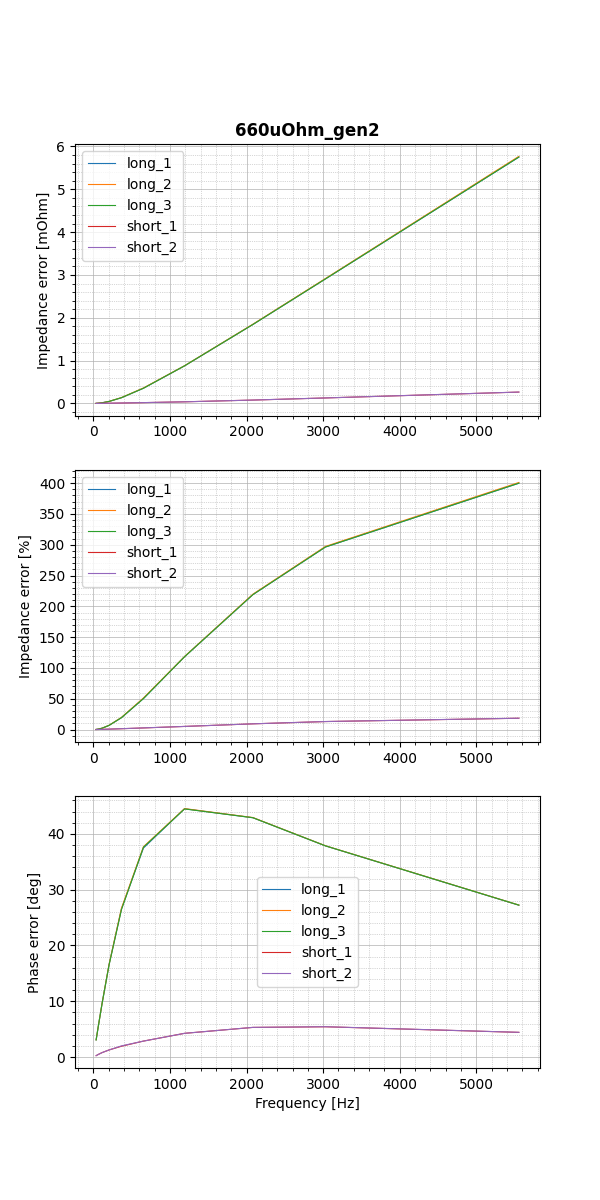

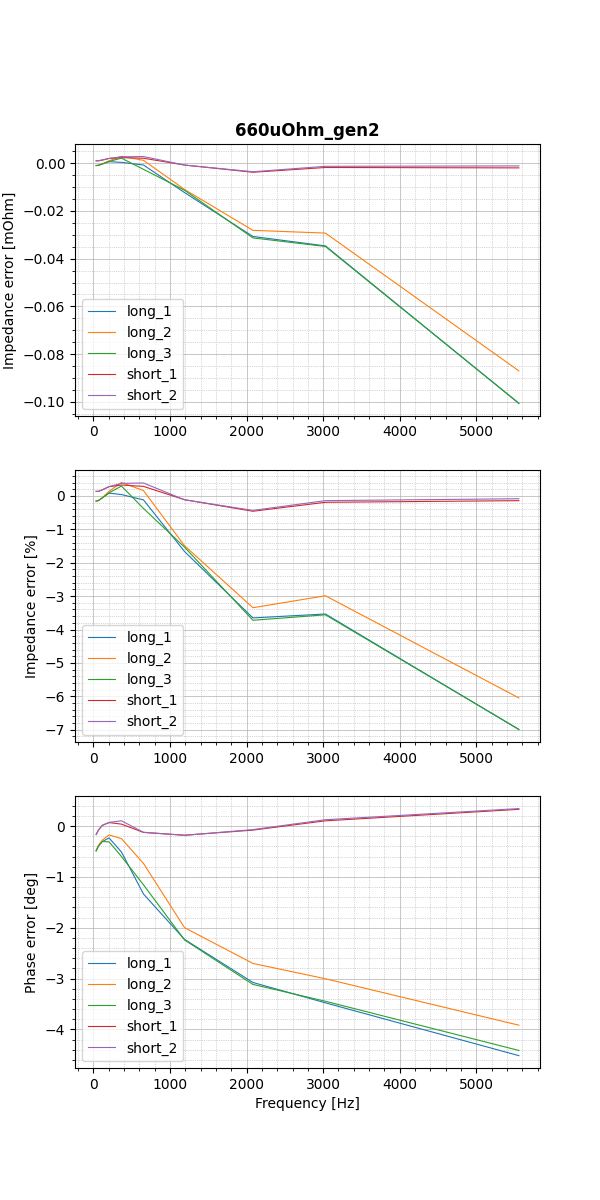

In [42]:
impedance_values = ['250uOhm_gen2', '1mOhm_gen2', '2mOhm_gen2','660uOhm_gen2']
#impedance_values = ['1mOhm_gen2','250uOhm_gen2','500uOhm_gen2','Cell_ref']
#impedance_values = ['Cell_ref'] # , '1mOhm_gen2','500uOhm_gen2','250uOhm_gen2',
%matplotlib widget

for impedance_value in impedance_values:
    plot_muliple_nyquist(eis_sweeps, impedance_value=impedance_value, references=refs, title=impedance_value, file_name='Nyquist_'+impedance_value+'.png', only_HF = False) # 'Nyquist_'+impedance_value+'.png'
    plot_muliple_nyquist(eis_sweeps_ac_corr, impedance_value=impedance_value, references=refs, title=impedance_value, file_name='Nyquist_cal_smooth_'+impedance_value+'.png', only_HF = False) # 'Nyquist_cal_smooth_'+impedance_value+'.png'
    plot_muliple_bode(eis_sweeps, impedance_value=impedance_value, references=refs, title=impedance_value, file_name='Bode_'+impedance_value+'.png', only_HF = False)
    plot_muliple_bode(eis_sweeps_ac_corr, impedance_value=impedance_value, references=refs, title=impedance_value, file_name='Bode_cal_smooth_'+impedance_value+'.png', only_HF = False)
    plot_multiple_std_dev(eis_sweeps, impedance_value, impedance_value, file_name='Std_'+impedance_value+'.png') #  'Std_'+impedance_value+'.png'
    plot_multiple_std_dev(eis_sweeps_ac_corr, impedance_value, impedance_value, file_name='Std_cal__smooth_'+impedance_value+'.png') # 'Std_cal'+impedance_value+'.png'
    plot_mulitple_bode_comparion(eis_sweeps, refs, impedance_value, impedance_value, file_name='Error_'+impedance_value+'.png')
    plot_mulitple_bode_comparion(eis_sweeps_ac_corr, refs, impedance_value, impedance_value, file_name='Error_cal_smooth_'+impedance_value+'.png') #'Error_cal_smooth_'+impedance_value+'.png'

### Testing correction

In [158]:
import numpy as np
from scipy.optimize import fsolve

def deduce_calibration_params(ref1, ref2):
    """
    Deduce calibration parameters from two reference measurements.
    
    Each reference should be a dictionary with the following keys:
        'R_ref': known (true) resistance of the reference standard (ohms)
        'X_ref': known (true) reactance of the reference standard (ohms)
        'R_meas': measured resistance (ohms)
        'X_meas': measured reactance (ohms)
    
    The measurement model is:
      Z_meas = G * [Z_ref + Z_fixture] * exp(j * phase_error),
    where:
      Z_ref = R_ref + j*X_ref   (known for each standard)
      Z_fixture = R_fixture + j*X_fixture   (unknown, same for all)
    
    Unknown calibration parameters:
        G           : gain error (scalar)
        phase_error : phase error (radians)
        R_fixture   : fixture resistance (ohms)
        X_fixture   : fixture reactance (ohms)
    
    Returns:
        G, phase_error, R_fixture, X_fixture
    """
    # Unpack reference 1 values
    R1 = ref1['R_ref']
    X1 = ref1['X_ref']
    R1_meas = ref1['R_meas']
    X1_meas = ref1['X_meas']
    
    # Unpack reference 2 values
    R2 = ref2['R_ref']
    X2 = ref2['X_ref']
    R2_meas = ref2['R_meas']
    X2_meas = ref2['X_meas']
    
    # Define the system of equations.
    # p = [G, theta, R_fixture, X_fixture]
    def equations(p):
        G, theta, R_fix, X_fix = p
        # For reference 1:
        eq1 = G * ((R1 + R_fix)*np.cos(theta) - (X1 + X_fix)*np.sin(theta)) - R1_meas
        eq2 = G * ((R1 + R_fix)*np.sin(theta) + (X1 + X_fix)*np.cos(theta)) - X1_meas
        # For reference 2:
        eq3 = G * ((R2 + R_fix)*np.cos(theta) - (X2 + X_fix)*np.sin(theta)) - R2_meas
        eq4 = G * ((R2 + R_fix)*np.sin(theta) + (X2 + X_fix)*np.cos(theta)) - X2_meas
        return [eq1, eq2, eq3, eq4]
    
    # Initial guess: assume no gain error, no phase error, and zero fixture impedance.
    p0 = [1.0, 0.0, 0.0, 0.0]
    
    solution, infodict, ier, mesg = fsolve(equations, p0, full_output=True)
    if ier != 1:
        raise RuntimeError("Calibration parameters did not converge: " + mesg)
    
    G, theta, R_fix, X_fix = solution
    return G, theta, R_fix, X_fix

def correct_impedance(Z_meas, G, phase_error, R_fixture, X_fixture):
    """
    Correct the measured impedance Z_meas using the calibration parameters.
    
    The measurement model is:
       Z_meas = G * [Z_ref + (R_fixture + j*X_fixture)] * exp(j*phase_error),
    where Z_ref is the true impedance of the device under test.
    
    Solve for Z_ref:
       Z_ref = Z_meas/(G*exp(j*phase_error)) - (R_fixture + j*X_fixture)
    
    Parameters:
        Z_meas     : Measured impedance (complex number)
        G          : Gain error (scalar)
        phase_error: Phase error (radians)
        R_fixture  : Fixture resistance (ohms)
        X_fixture  : Fixture reactance (ohms)
    
    Returns:
        Z_ref      : Corrected (true) impedance (complex number)
    """
    Z_ref = Z_meas / (G * np.exp(1j * phase_error)) - (R_fixture + 1j * X_fixture)
    return Z_ref

In [162]:
import cmath
import math

def apply_transformation(complex_num, real_constant, phase_shift_degrees):
    # Multiply by real constant
    scaled_complex = complex_num * real_constant
    
    # Convert phase shift to radians
    phase_shift_radians = math.radians(phase_shift_degrees)
    
    # Apply phase shift (rotate in complex plane)
    shifted_complex = scaled_complex * cmath.exp(1j * phase_shift_radians)
    
    return shifted_complex

z = complex(0.1, 1+5)  # Example complex number
k = 1.05              # Real constant
theta_degrees = 15  # Phase shift in degrees

result = apply_transformation(z, k, theta_degrees)
print(f"Original: {z}")
print(f"Transformed: {result}")

z = complex(5, 3+5)  # Example complex number
k = 1.05              # Real constant
theta_degrees = 15  # Phase shift in degrees

result = apply_transformation(z, k, theta_degrees)
print(f"Original: {z}")
print(f"Transformed: {result}")

z = complex(1, 1+5)  # Example complex number
k = 1.05              # Real constant
theta_degrees = 15  # Phase shift in degrees

result = apply_transformation(z, k, theta_degrees)
print(f"Original: {z}")
print(f"Transformed: {result}")


Original: (0.1+6j)
Transformed: (-1.5291377723855286+6.1125087053568965j)
Original: (5+8j)
Transformed: (2.8970306091564346+9.472576927616409j)
Original: (1+6j)
Transformed: (-0.6163378665423591+6.357092702978778j)


In [165]:
# Define two reference measurements.
# For each reference, supply:
#   'R_ref': known resistance of the standard
#   'X_ref': known reactance of the standard
#   'R_meas': measured resistance
#   'X_meas': measured reactance
ref1 = {
    'R_ref': 0.1,    # ohms
    'X_ref': 6,    # ohms
    'R_meas': -1.4,   # ohms (example measured value)
    'X_meas': 6.2    # ohms (example measured value)
}

ref2 = {
    'R_ref': 5,    # ohms
    'X_ref': 8,    # ohms
    'R_meas': 2.9,  # ohms (example measured value)
    'X_meas': 9.3    # ohms (example measured value)
}

# Deduce calibration parameters:
G, phase_error, R_fixture, X_fixture = deduce_calibration_params(ref1, ref2)
print("Gain error (G):", G)
print("Phase error (degrees):", phase_error*360/(2*np.pi))
print("Fixture resistance (R_fixture, ohms):", R_fixture)
print("Fixture reactance (X_fixture, ohms):", X_fixture)

# Suppose we measure an impedance:
Z_meas = -0.6 + 1j*6.3  # example measured impedance (ohms)

# Correct Z_meas to obtain the true device impedance Z_ref:
Z_ref = correct_impedance(Z_meas, G, phase_error, R_fixture, X_fixture)
print("Corrected impedance (Z_ref):", Z_ref)

Gain error (G): 1.001605280619546
Phase error (degrees): 13.585494927125017
Fixture resistance (R_fixture, ohms): -0.004626334519889219
Fixture reactance (X_fixture, ohms): 0.34519572953763367
Corrected impedance (Z_ref): (0.899822064057147+5.909430604981898j)
